In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_feather("data/dataset.feather")
print(df.shape)

(14000, 1317)


In [8]:
label_cols = ["kl_div_blowup_step", "plateau_length"]
# label_cols = ['kl_div_blowup_step']
exclude_cols = [
    "id",
    "start_prompt",
    "end_prompt",
    "perturbation_type",
    "final_kl_div",
    "perturbation_type",
    "kl_div_blowup_step",
    "plateau_length",
]
exclude_cols = set(exclude_cols) | set(label_cols)
feature_cols = [c for c in df.columns if c not in exclude_cols]

## Correlations

In [108]:
# # TODO: Fix this
# df[feature_cols + label_cols].corr().filter(label_cols).drop(label_cols)

,kl_div_blowup_step,plateau_length
prompts_cos_sim,-0.014816,0.034132
prompts_token_sim,0.029218,0.039694
final_l2_norm,-0.216205,-0.311097
final_cos_sim,0.181529,0.268958
total_unique_active_features,-0.075158,-0.133815
avg_feature_activation_count,0.174676,0.207678
avg_active_features,-0.063140,-0.121803
std_active_features,-0.067059,-0.121700
avg_feature_activation,0.087992,0.065763
std_feature_activation,-0.116182,-0.149961


## Modelling

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [16]:
X, y = df[feature_cols].to_numpy(), df[label_cols].to_numpy()

In [17]:
X.shape, y.shape

((14000, 1310), (14000, 2))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.075, random_state=42
)

print(X_train.shape, X_test.shape)

(12950, 1310) (1050, 1310)


In [25]:
# Comment out this block if you don't want to normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Feature Selection

In [38]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=xgb.XGBRegressor(), threshold="median")
X_selected = selector.fit_transform(X_train_scaled, y_train)

### Finding good hyperparams

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "estimator__n_estimators": [100, 200, 300, 400, 500],
    "estimator__max_depth": [3, 5, 7, 10, 13, 15],
    "estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
}
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1
)
random_search.fit(X_selected, y_train)
best_model = random_search.best_estimator_

In [54]:
X_selected.shape

(12950, 655)

In [56]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and targets
X_sample, _, y_sample, _ = train_test_split(
    X_selected, y_train, train_size=0.1, random_state=42
)

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1
)
# random_search.fit(X_sample, y_sample)

In [57]:
import time

start_time = time.time()
model.fit(X_sample, y_sample)
end_time = time.time()

print(f"Single fit took {end_time - start_time} seconds")

Single fit took 29.705750703811646 seconds


### Training the models

In [94]:
reg_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=0.1,
    n_jobs=-1,
)
model = MultiOutputRegressor(reg_model)

In [72]:
# from sklearn.ensemble import StackingRegressor, RandomForestRegressor
# from sklearn.linear_model import Ridge, LassoCV
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.svm import SVR

# # Define base estimators
# xgb_model = xgb.XGBRegressor(
#     n_estimators=100, max_depth=6, learning_rate=0.1,
#     random_state=42, reg_alpha=0.1, reg_lambda=0.1,
#     device='cuda'
# )
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)

# # Create the StackingRegressor
# stacking_regressor = StackingRegressor(
#     estimators=[
#         ('xgb', xgb_model),
#         ('rf', rf_model)
#     ],
#     final_estimator=Ridge()
# )

# # Wrap StackingRegressor with MultiOutputRegressor
# stacking_regressor = MultiOutputRegressor(stacking_regressor, n_jobs=-1)

In [ ]:
# estimators = [
#     ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_jobs=-1))),
#     ('rf', MultiOutputRegressor(RandomForestRegressor(n_jobs=-1))),
#     ('ridge', MultiOutputRegressor(Ridge())),
#     ('svr', MultiOutputRegressor(SVR()))
# ]

# stacking_regressor = StackingRegressor(
#     estimators=estimators,
#     final_estimator=MultiOutputRegressor(LassoCV(n_jobs=-1)),
#     n_jobs=-1
# )

In [76]:
# ! pip install cupy

In [78]:
# import cupy as cp

# # Convert your data to GPU
# X_selected_gpu = cp.array(X_selected)
# y_train_gpu = cp.array(y_train)

In [102]:
model.fit(X_train_scaled, y_train)

# Fit the model
# stacking_regressor.fit(X_selected, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [107]:
X_test_selected = selector.transform(X_test_scaled)

y_pred = model.predict(X_test_scaled)

# y_pred = stacking_regressor.predict(X_test_selected)

In [108]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
r2 = r2_score(y_test, y_pred, multioutput="raw_values")

In [109]:
# Print results
for i, col in enumerate(label_cols):
    print(f"Target: {col}")
    print(f"MSE: {mse[i]:.4f}")
    print(f"R-squared: {r2[i]:.4f}")
    print()

Target: kl_div_blowup_step
MSE: 16.9172
R-squared: 0.8142

Target: plateau_length
MSE: 14.5859
R-squared: 0.8686



In [ ]:
# Target: kl_div_blowup_step
# MSE: 16.9172
# R-squared: 0.8142

# Target: plateau_length
# MSE: 14.5859
# R-squared: 0.8686

In [217]:
# Feature importance
feature_importance = np.mean(
    [estimator.feature_importances_ for estimator in model.estimators_], axis=0
)
feature_importance_df = pd.DataFrame(
    {"feature": feature_cols, "importance": feature_importance}
).sort_values("importance", ascending=False)

print("Feature Importance:")
print(feature_importance_df.head(50))

Feature Importance:
                                 feature  importance
1300  100_act_top_1_sae_feature_sparsity    0.033482
1287   99_act_top_1_sae_feature_sparsity    0.018098
91      7_act_top_1_sae_feature_sparsity    0.013908
1066   82_act_top_1_sae_feature_sparsity    0.012325
68      5_act_top_2_sae_feature_act_norm    0.010296
156    12_act_top_1_sae_feature_sparsity    0.009713
975    75_act_top_1_sae_feature_sparsity    0.009533
949    73_act_top_1_sae_feature_sparsity    0.008428
38      3_act_top_1_sae_feature_act_norm    0.008312
7                    std_active_features    0.008167
192          15_act_top_1_sae_feature_id    0.007677
143    11_act_top_1_sae_feature_sparsity    0.007614
848    65_act_top_2_sae_feature_act_norm    0.006601
470         36_act_top_2_sae_feature_act    0.006408
169    13_act_top_1_sae_feature_sparsity    0.005767
19           1_act_top_3_sae_feature_act    0.005654
257          20_act_top_1_sae_feature_id    0.005316
234    18_act_top_1_sae_fe

In [101]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(feature_importance_df.head(25)["feature"], feature_importance_df.head(25)["importance"])
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.tight_layout()
# plt.show()

In [37]:
# ! du -sh observations

## Plotting predictions

In [126]:
from glob import glob
import json
import matplotlib.pyplot as plt

In [ ]:
X_scaled = scaler.transform(X)

In [118]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data

In [119]:
raw_observations = []

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    raw_observations.extend(obs_data)

In [216]:
# df.sample(5)

In [211]:
df[df.final_kl_div >= 1].sample(
    5
)  # .sort_values(by='kl_div_blowup_step', ascending=False)

,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,100_act_top_1_sae_feature_sparsity,100_act_top_2_sae_feature_id,100_act_top_2_sae_feature_act,100_act_top_2_sae_feature_act_norm,100_act_top_2_sae_feature_sparsity,100_act_top_3_sae_feature_id,100_act_top_3_sae_feature_act,100_act_top_3_sae_feature_act_norm,100_act_top_3_sae_feature_sparsity,100_act_l2_norm
8909,1669531d-cfa8-4230-9d10-8c389829b190,Part I and part II) was about how sometimes,I’m Ophelia Benson. I,0.746689,0.1,43,37,plateau_then_rapid,6.417775,3.559604,...,0.002880,24182,0.586653,0.11,0.090893,15603,0.560923,0.10,0.119497,3.559604
11438,fba8de31-a7a4-44c5-a71b-61aa85cb0847,". For instance, delaying certain Obamacare pro...",sorry. The missel-what? Can the,0.813280,0.1,47,39,plateau_then_rapid,4.508910,3.572345,...,0.014296,15603,0.451864,0.10,0.119497,24182,0.307771,0.07,0.090893,3.572345
2686,3c970755-23e3-4933-966a-e7a7459a5b8a,"......this is exactly what our cities need."" --",and Washington left and radical organizations...,0.766232,0.0,53,46,plateau_then_rapid,2.216237,3.200330,...,0.009248,19064,0.648690,0.14,0.043999,15603,0.519837,0.11,0.119497,3.200330
3637,93a2a499-7113-4793-9ec4-8b1d6a875a63,team’s loss at Stanford last month to,"beluga whale, harbor porpoise, bearded",0.673710,0.0,40,14,plateau_then_rapid,1.767500,4.389200,...,0.000300,4555,0.832800,0.08,0.000100,15603,0.551000,0.05,0.119500,4.389200
7294,36bfe62b-7881-451b-a15a-0015fb55db21,"set up defenses, but then if you are going","2 Corsi For Percentage (CF%), paired with",0.689442,0.0,49,38,plateau_then_rapid,7.540189,2.975606,...,0.003500,15603,0.591929,0.12,0.119497,24171,0.469955,0.09,0.020164,2.975606


In [198]:
# obs_idxs = df.sample(5).index.tolist()

In [212]:
obs_idxs = [10362, 9290, 5290, 5365, 11438, 7294]
steps = np.arange(0, 100, 1)

In [213]:
sample = X_scaled[obs_idxs]
preds = model.predict(sample)

In [214]:
import matplotlib.pyplot as plt
import numpy as np


def plot_kl_divergence(obs_idxs, df, raw_observations, preds, steps, cmap="viridis"):
    plt.figure(figsize=(12, 6))

    # Get the colormap
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, len(obs_idxs)))

    for i, (obs_idx, color) in enumerate(zip(obs_idxs, colors)):
        props = dict(df.loc[obs_idx])
        obs = raw_observations[obs_idx]
        kl_divs = [s["kl_div"] for s in obs["steps"]]

        label = f"Actual: blowup={props['kl_div_blowup_step']:.0f}, plateau={props['plateau_length']:.0f}"
        plt.plot(steps, kl_divs, label=label, color=color)

        # Mark predicted blowup step with a diamond
        pred_blowup = preds[i][0]
        plt.plot(
            pred_blowup,
            np.interp(pred_blowup, steps, kl_divs),
            marker="v",
            markersize=7,
            color=color,
        )

        # Mark predicted plateau finish with a square
        pred_plateau = int(preds[i][1])
        plateau_end = min(pred_plateau, len(steps) - 1)
        plt.plot(
            plateau_end, kl_divs[plateau_end], marker="o", markersize=7, color=color
        )

    plt.xlabel("Steps")
    plt.ylabel("KL Divergence")
    plt.title("Steps vs KL Divergence with Model Predictions")
    plt.xticks(np.arange(0, max(steps) + 5, 5))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

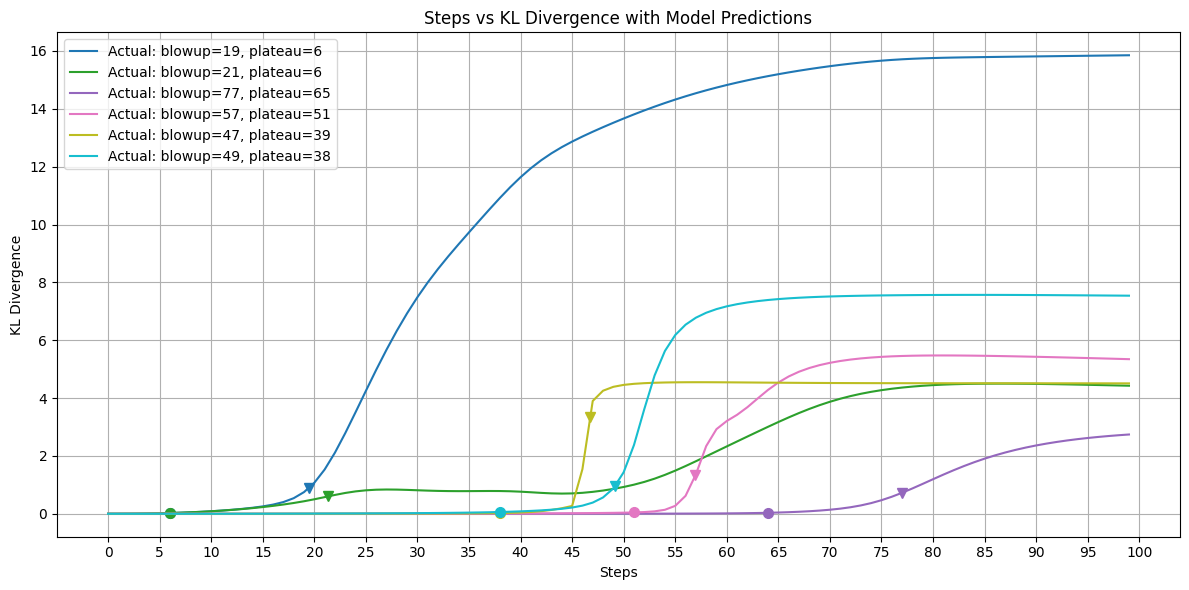

In [215]:
plot_kl_divergence(obs_idxs, df, raw_observations, preds, steps, cmap="tab10")